<img src="https://drive.google.com/uc?export=view&id=1Q6vQcIWFPY27isBepABpJ7nroUNKox_Z" width="100%">

# **Clasificación de Textos**
---

En este notebook presentaremos los conceptos del análisis supervisado de textos junto con un ejemplo práctico de clasificación.

Comenzamos importando las librerías necesarias:

In [1]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.7 MB/s eta 0:00:00


In [2]:
import re
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from unidecode import unidecode
plt.style.use("ggplot")

## **1. Análisis Supervisado**
---

El análisis supervisado de textos es una tarea donde se implementan modelos para replicar el comportamiento de un humano en una tarea específica. Actualmente esta tarea va muy de la mano con el aprendizaje supervisado en _machine learning_.

Existen distintas tareas en procesamiento de lenguaje natural que se pueden abordar como un enfoque supervisado, entre ellas: clasificación de tokens, clasificación de textos, traductores, llenado de máscaras, análisis de sentimientos, entre otras. En la siguiente figura podemos ver el proceso general del análisis supervisado de textos:

<img src="https://drive.google.com/uc?export=view&id=1P7wvAsHTCWAfZZeci9WKmtJWK-0u_-Ci" width="100%">

Este proceso consiste en cuatro etapas:

1. **Preprocesamiento**: consiste en la preparación de los textos para simplificar el entrenamiento de un modelo, generalmente esta etapa involucra tareas como normalización, tokenización, eliminación de stopwords, y otras tareas tal y como se presentó en la unidad 2.
2. **Extracción de características**: en este caso se extrae una representación numérica o características con las que se pueda modelar el texto, tal y como se presentó en la unidad 3.
3. **Construcción del modelo**: en esta etapa se entrena un modelo supervisado de _machine learning_ para cumplir una tarea en específico (por ejemplo, clasificación, regresión, modelos secuencia a secuencia)
4. **Evaluación del modelo**: en esta última parte se evalúa el desempeño del modelo para evaluar la generalización del mismo en la tarea en cuestión.

En NLP, el enfoque supervisado más común es la tarea de clasificación, en especial, ya que una palabra puede ser vista como una categoría y un vocabulario como todas las categorías posibles. De esta forma funcionan modelos para reconocimiento de entidades nombradas, part-of-speech, llenado de máscaras, autocompletadores, entre otras. Varias de estas aplicaciones las profundizaremos en los otros notebooks de esta unidad. Por el momento, nos enfocaremos en una aplicación relacionada con la clasificación de documentos: el análisis de sentimientos.

## **2. Análisis de Sentimientos**
---

El análisis de sentimientos, o minería de opinión, es un campo del procesamiento de lenguaje natural que busca identificar y extraer opiniones de un texto dado. Su propósito principal es identificar actitudes, sentimientos, evaluaciones y emociones de algún orador o escritor por medio de análisis computacional. Por ejemplo, en la siguiente figura podemos ver un caso de análisis de sentimientos aplicado en la identificación del sentimiento en reviews sobre la película [Fragmentado](https://es.wikipedia.org/wiki/Split_(pel%C3%ADcula)):

<img src="https://drive.google.com/uc?export=view&id=1QCEsPK7ganFQ0SEt8Cn9B3gi2diQwx-F" width="100%">

El análisis de sentimientos se utiliza en diversas aplicaciones:

- **Comercio**: las empresas utilizan el análisis de sentimientos para desarrollar sus estrategias y entender la respuesta emocional de los usuarios ante determinado producto o marca. De igual forma, permite evaluar cómo la gente reacciona a determinada campaña para comprender por qué algunos productos no son comprados.
- **Política**: en este ámbito se puede utilizar para dar un seguimiento a campañas políticas, detectar las acciones y las propuestas del gobierno, evaluar la favorabilidad de un candidato en específico, predecir resultados electorales, entre otros.
- **Acciones públicas**: se usa para monitorear y analizar fenómenos sociales, en especial, permite identificar eventos específicos que puedan estar relacionados con situaciones peligrosas o fuera de la ley.
- **Salud**: puede usarse para estudiar e identificar trastornos clínicos como depresión, ansiedad, autolesiones, autismo, entre otras.

Normalmente, el análisis de sentimientos se aborda como clasificación de documentos en una o varias categorías (sentimientos o emociones).

Para este caso, usaremos el conjunto de datos [Twitter Sentiment Analysis](https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis) de Kaggle. Comenzamos cargándolo:

In [3]:
data = pd.read_parquet("https://raw.githubusercontent.com/mindlab-unal/mlds4-datasets/main/u4/twitter_sentiment.parquet")
display(data.head())

,category,text
2000,Negative,"At the same time, there are many low-income co..."
2001,Negative,"Italy, Italy, Italy, Italy, Italy, Italy, Ital..."
2002,Negative,"Finally, Kingdom Come:. Deliverance... The per..."
2003,Negative,"When fear is raised that ""punk-2077"" may be po..."
2004,Negative,Facebook spent the second day after I was bann...


Como podemos ver, es un corpus que contiene dos columnas:

- `category`: tipo de sentimiento asociado al texto.
- `text`: texto del documento.

Se trata de textos extraídos de Twitter y etiquetados en 3 categorías:

- `Negative`: sentimiento negativo.
- `Positive`: sentimiento positivo.
- `Neutral`: sentimiento neutral.

Veamos la distribución de las etiquetas:

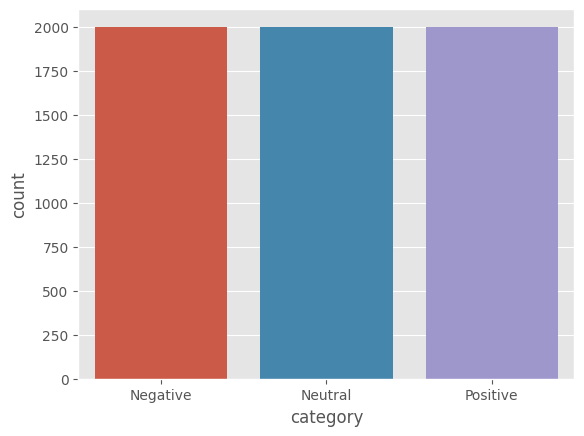

In [4]:
counts = (
        data
        .category
        .value_counts()
        .reset_index()
        )
fig, ax = plt.subplots()
sns.barplot(data=counts, x="category", y="count", ax=ax, hue="category")
fig.show()

Para este ejemplo, usaremos el siguiente *pipeline* de `spacy` para tokenización y eliminación de stopwords.

In [5]:
nlp = spacy.blank("en")
display(nlp)

Ahora, definimos una función de preprocesamiento:

In [6]:
def preprocess(text):
    doc = nlp(text) # creamos documento de spacy
    filtered_tokens = " ".join(
            token.text
            for token in doc
            if not token.is_stop and
            len(token) > 3 and len(token) < 24
            ) # filtramos stopwords y palabras por longitud
    lower_text = filtered_tokens.lower() # texto en minúscula
    norm_text = unidecode(lower_text) # texto normalizado
    clean_text = re.sub(r"[^a-z ]", " ", norm_text) # eliminamos caracteres especiales
    spaces_text = re.sub(r"\s+", " ", clean_text) # eliminamos espacios repetidos
    strip_text = spaces_text.strip() # eliminamos espacios de inicio y final
    if not len(strip_text): # validamos si el documento tiene longitud
        return None
    else:
        return strip_text

Aplicamos la función de preprocesamiento sobre todo el corpus:

In [7]:
data_na = data.dropna()
data_prep = (
        data_na
        .assign(text=data_na.text.apply(preprocess))
        .dropna()
        )
display(data_prep.sample(5))

,category,text
6120,Positive,finally played borderlands actual game play gr...
6064,Positive,kind incredible games getting year xbox series...
3169,Negative,news microsoft million customer service record...
6286,Positive,modern warfare considered best duty youtube wi...
5270,Neutral,changes fallout thinking right passage great a...


## **3. Clasificación con Bolsas de Palabras**
---

Primero veremos un ejemplo de clasificación de sentimientos usando una representación basada en bolsa de palabras como técnica de extracción de características.

### **3.1. Extracción de Características**
---

Comenzamos importando el vectorizador de `sklearn`:

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

Obtenemos una representación de bolsa de palabras del corpus:

In [ ]:
vect = CountVectorizer(max_features=5000).fit(data_prep.text)
display(vect)

Podemos obtener la matriz de características:

In [ ]:
features = vect.transform(data_prep.text).toarray()
display(features.shape)

Como podemos ver, tenemos un total de 5993 documentos y un vocabulario de tamaño 5000.

### **3.2. Modelamiento**
---

Uno de los conceptos claves relacionados al entrenamiento de modelos supervisados es la **validación cruzada**, se trata de una estrategia para validar qué tan generalizable es un modelo.

En este caso usaremos una estrategia de validación cruzada conocida como K-fold cross-validation:

  <img src="https://drive.google.com/uc?export=view&id=1gta4-p20xuFQq3gTqKN6MeATY624M1ML" width="80%">

Esto nos permite evaluar distintas configuraciones de un modelo (hiper-parámetros) y evaluar una métrica $K$ veces para obtener un buen estimador de alguna métrica de desempeño.

> **Nota**: el detalle de la metodología de validación cruzada y de los modelos se estudia con mayor profundidad en el **módulo 2 de introducción a machine learning**. En este notebook veremos de forma práctica la metodología enfocándonos más en su aplicación en el procesamiento de lenguaje natural.

Comenzamos importando `LabelEncoder` de `sklearn` para codificar los sentimientos de una forma compatible con un modelo:

In [ ]:
from sklearn.preprocessing import LabelEncoder

Obtenemos las etiquetas codificadas:

In [ ]:
labeler = LabelEncoder().fit(data_prep.category)
display(labeler)

Ahora, codificamos las etiquetas:

In [ ]:
labels = labeler.transform(data_prep.category)
display(np.unique(labels))

Como podemos ver, las etiquetas fueron codificadas como números enteros, podemos ver la correspondencia entre cada categoría y cada número (dada por el orden de las categorías en el siguiente arreglo):

In [ ]:
display(labeler.classes_)

Ahora importamos la función `train_test_split` para dividir el conjunto de datos en entrenamiento (ajuste del modelo) y prueba (evaluación del desempeño sobre datos no vistos):

In [ ]:
from sklearn.model_selection import train_test_split

Particionamos el conjunto de datos:

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features,
    labels,
    test_size=0.4, # tamaño del conjunto de prueba
    random_state=13, # semilla de números aleatorios
    stratify=labels, # mantenemos distribución de etiquetas
    )

Veamos el tamaño de las matrices de entrenamiento y prueba:

In [ ]:
display(features_train.shape)
display(features_test.shape)

Ahora podemos entrenar un modelo. Es posible usar cualquier tipo de modelo de clasificación como:
- bosques aleatorios
- máquinas de soporte vectorial
- redes neuronales
- entre otros

En este caso utilizaremos un clasificador **Bayesiano ingenuo multinomial** (*multinomial Naive Bayes*), el cual es un algoritmo de aprendizaje automático utilizado para clasificar documentos de texto basados en bolsas de palabras. El algoritmo funciona asumiendo que cada característica (palabra) en el texto es independiente de las demás características y tiene una distribución multinomial como verosimilitud, y que la probabilidad de una característica dada una clase es proporcional a la frecuencia de esa característica en el texto de esa clase. Utiliza la probabilidad _a priori_ de cada clase para calcular la probabilidad a posteriori de cada clase dado el texto, y finalmente, asigna la clase con la probabilidad _a posteriori_ más alta al texto, como se muestra en la siguiente ecuación:

<img src="https://drive.google.com/uc?export=view&id=1FPZiKYUZ1tLieT1g7XyKAltDj90FcAig" width="80%">

Es un modelo ampliamente utilizado en problemas de clasificación de texto como el análisis de sentimientos y la clasificación de correo no deseado. Veamos cómo importar el modelo:

In [ ]:
from sklearn.naive_bayes import MultinomialNB

Este modelo utiliza internamente probabilidades junto con la regla de Bayes para dar la probabilidad de que un documento pertenezca a una categoría. Para esto, hace uso de un hiper-parámetro `alpha` que permite controlar qué tan suave se realiza la asignación de un documento en una categoría; se trata de un número que debe ser explorado entre 0 y el número de documentos.

Definimos un rango para el hiper-parámetro:

In [ ]:
param_grid = {"alpha": 10 ** np.arange(5)}
display(param_grid)

Ahora importamos la clase `GridSearchCV` para implementar la estrategia de K-fold cross-validation y encontrar el mejor valor de `alpha`:

In [ ]:
from sklearn.model_selection import GridSearchCV

Realizamos el entrenamiento y la exploración:

In [ ]:
gsearch = GridSearchCV(
    MultinomialNB(),
    param_grid=param_grid,
    cv=3
    ).fit(features_train, labels_train)

Veamos la exactitud del modelo en la clasificación de sentimientos para los distintos valores de `alpha`:

In [ ]:
results = pd.DataFrame(gsearch.cv_results_)
display(results)

Extraemos el modelo que mejor funciona:

In [ ]:
model = gsearch.best_estimator_
display(model)

### **3.3. Evaluación**
---

Veamos el desempeño del modelo sobre datos no vistos (conjunto de evaluación o *test*) usando métricas de desempeño para clasificación.

`sklearn` nos permite evaluar las métricas más importantes usando la función `classification_report`. La podemos importar así:

In [ ]:
from sklearn.metrics import classification_report

Obtenemos las predicciones sobre el conjunto de prueba:

In [ ]:
predictions = model.predict(features_test)
print(classification_report(labels_test, predictions))

Como podemos ver, el modelo tiene un accuracy de 0.84 en la clasificación de los 3 sentimientos.

También podemos calcular una matriz de confusión para ver errores específicos en la clasificación, para esto importamos `confusion_matrix`:

In [ ]:
from sklearn.metrics import confusion_matrix

Calculamos la matriz:

In [ ]:
cm = confusion_matrix(labels_test, predictions)
cm = pd.DataFrame(data=cm, columns=labeler.classes_, index=labeler.classes_)

Veamos una visualización de la matriz de confusión:

In [ ]:
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax)
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
fig.show()

Por último, veamos un ejemplo de clasificación de sentimientos para un texto arbitrario:

In [ ]:
text = "this game is trash"

Veamos el flujo completo:

- Preprocesamiento:

In [ ]:
prep_text = preprocess(text)
display(prep_text)

- Extracción de características:

In [ ]:
features = vect.transform([prep_text])
display(features)

- Modelo:

In [ ]:
prediction = model.predict(features)
display(prediction)

Por último, decodificamos la predicción:

In [ ]:
display(labeler.inverse_transform(prediction))

Con esto tenemos un modelo personalizado para análisis de sentimientos basado en bolsas de palabras.

## **4. Clasificación con Embeddings**
---

También podemos utilizar otros tipos de representaciones para manejar los documentos. Como en este caso buscamos clasificar documentos completos, y no palabras, vamos a usar un embedding **Doc2Vec**.

> **Nota**: si se busca clasificar tokens, puede utilizar representaciones como bolsas de N-grams a nivel de caracteres, Word2Vec o FastText.

### **4.1. Extracción de Características**
---

Para la extracción de características importamos el modelo `Doc2Vec` de `gensim`:

In [ ]:
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

Creamos el corpus anotado:

In [ ]:
tagged_corpus = [
        TaggedDocument(doc.split(), [i])
        for i, doc in enumerate(data_prep.text.to_list())
        ]

Ahora entrenamos el embedding:

In [ ]:
embedding = Doc2Vec(
        tagged_corpus,
        vector_size=500,
        alpha=1e-3,
        epochs=1000,
        workers=-1
        )
display(embedding)

Obtenemos una matriz de características basada en este embedding:

In [ ]:
features = list(map(lambda doc: embedding.infer_vector(doc.words), tagged_corpus))
features = np.vstack(features)
display(features.shape)

También debemos codificar las etiquetas:

In [ ]:
labeler = LabelEncoder().fit(data_prep.category)
display(labeler)

Obtenemos las etiquetas codificadas:

In [ ]:
labels = labeler.transform(data_prep.category)

### **4.2. Modelamiento**
---

Al igual que en el caso anterior, vamos a seguir una metodología de validación cruzada para determinar la generalización del modelo y seleccionar hiper-parámetros. Comenzamos particionando el conjunto de datos:

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features,
    labels,
    test_size=0.4, # tamaño del conjunto de prueba
    random_state=13, # semilla de números aleatorios
    stratify=labels, # mantenemos distribución de etiquetas
    )

Veamos el tamaño de las matrices:

In [ ]:
display(features_train.shape)
display(features_test.shape)

En este caso utilizaremos un clasificador **Bayesiano ingenuo Gaussiano** (*Gaussian Naive Bayes*), el cual es un algoritmo de aprendizaje automático que se utiliza para clasificar documentos de texto basados en embeddings. En lugar de tratar con características discretas como las palabras individuales, se emplean embeddings para representar cada documento de texto como un vector continuo en un espacio de características de alta dimensión. El algoritmo asume que los embeddings de los documentos de una clase determinada se distribuyen de manera gaussiana en el espacio de características, y usa la media y la varianza de esta distribución para calcular la probabilidad de que un nuevo documento pertenezca a esa clase. Utiliza la probabilidad _a priori_ de cada clase para calcular la probabilidad _a posteriori_ de cada clase dado el texto, y finalmente, asigna la clase con la probabilidad _a posteriori_ más alta al texto, como se muestra en la siguiente ecuación:

<img src="https://drive.google.com/uc?export=view&id=1QxbbA9_zfIwteHX2lrG04zRZbvQxbDMK" width="80%">

Veamos cómo importar el modelo:

In [ ]:
from sklearn.naive_bayes import GaussianNB

Este modelo tiene como hiper-parámetro `var_smoothing`, el cual funciona de una forma equivalente al parámetro `alpha` en la versión multinomial. Definimos el rango de valores a explorar:

In [ ]:
param_grid = {"var_smoothing": 10. ** np.arange(-9, -3)}
display(param_grid)

Ahora entrenamos el modelo:

In [ ]:
gsearch = GridSearchCV(
    GaussianNB(),
    param_grid=param_grid,
    cv=3
    ).fit(features_train, labels_train)

Veamos los resultados de la exploración de hiper-parámetros:

In [ ]:
display(pd.DataFrame(gsearch.cv_results_))

Extraemos el mejor modelo:

In [ ]:
model = gsearch.best_estimator_
display(model)

### **4.3. Evaluación**
---

Extraemos las predicciones del modelo sobre el conjunto de prueba:

In [ ]:
predictions = model.predict(features_test)

Veamos el reporte de clasificación:

In [ ]:
print(classification_report(labels_test, predictions))

También podemos ver la matriz de confusión:

In [ ]:
cm = confusion_matrix(labels_test, predictions)
cm = pd.DataFrame(data=cm, columns=labeler.classes_, index=labeler.classes_)

Veamos una visualización de la matriz de confusión:

In [ ]:
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax)
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
fig.show()

Como podemos ver, el desempeño con **Doc2Vec** no es tan bueno. Recuerde que los _embeddings_ requieren una gran cantidad de datos y mucho tiempo de entrenamiento para llegar a representar de forma correcta un corpus. Para que este enfoque funcione mejor, necesitamos más datos o utilizar un modelo pre-entrenado en un corpus similar.

## **5. Clasificación con Vader**

Una alternativa para análisis de sentimientos es con modelos pre-entrenados o librerías diseñadas para ello. Un ejemplo de esto es [VADER](https://github.com/cjhutto/vaderSentiment) (*Valence Aware Dictionary and sEntiment Reasoner*). Se trata de una librería basada en reglas que usa léxicos para el análisis de sentimientos. Es una herramienta de uso libre que está enfocada en el análisis de datos en redes sociales y provee información acerca de los sentimientos en un texto (qué tan positivo o negativo es).

Algunas de las ventajas de VADER son:

- Funciona bien en datos de redes sociales, sin embargo, se puede generalizar en otros dominios.
- No requiere datos para el entrenamiento.
- Es lo suficientemente rápido como para ser usado con datos en streaming.

Comenzamos instalando la librería

In [ ]:
!pip install vaderSentiment

Para usar `vader` debemos importar la clase `SentimentIntensityAnalyzer`:

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Instanciamos el analizador de sentimientos:

In [ ]:
analyzer = SentimentIntensityAnalyzer()

Veamos un ejemplo de cómo podemos usar el analizador con un texto con sentimientos positivos:

In [ ]:
res = analyzer.polarity_scores(
        "I am happy today, because, it is my birthday."
        )
display(res)

También podemos hacerlo con un texto negativo:

In [ ]:
res = analyzer.polarity_scores(
        "I think I won't go, my grandma is ill."
        )
display(res)

El analizador nos da cuatro métricas:

- _neg, neu, pos_: son la proporción de expresiones negativas, neutrales y positivas encontradas en el texto.
- _compound_: se trata de una calificación que toma valores entre -1 y 1. Puede verse como el sentimiento del texto dado.

Así mismo, podemos clasificar el sentimiento del texto de acuerdo con la siguiente convención según los desarrolladores de la librería:

| Sentimiento | Compound |
| --- | --- |
| Negativo | $\text{compound}\leq -0.05$ |
| Neutral | $-0.05 < \text{compound} < 0.05$|
| Positivo | $\text{compound}\geq 0.05$ |

Además de analizar el léxico de las palabras, **VADER** incluye algunas reglas adicionales:

- **Puntuación**: el uso del signo de exclamación significa una mayor intensidad, sucesiones de signos de exclamación alteran el score total.

In [ ]:
display(analyzer.polarity_scores("That restaurant is really bad"))

In [ ]:
display(analyzer.polarity_scores("That restaurant is really bad!"))

In [ ]:
display(analyzer.polarity_scores("That restaurant is really bad!!"))

In [ ]:
display(analyzer.polarity_scores("That restaurant is really bad!!!"))

- **Mayúsculas**: palabras relevantes que estén en mayúsculas enfatizan el sentimiento.

In [ ]:
display(analyzer.polarity_scores("She was nice to me."))

In [ ]:
display(analyzer.polarity_scores("She was NICE to me"))

- **Modificadores de grado**: el uso de palabras para enfatizar un mayor grado también modifica el score final.

In [ ]:
display(analyzer.polarity_scores("She was partially nice to me."))

In [ ]:
display(analyzer.polarity_scores("She was extremely nice to me."))

- **Conjunciones**: algunas palabras pueden cambiar el sentimiento de una oración; **VADER** también tiene en cuenta estas conjunciones.

In [ ]:
display(analyzer.polarity_scores("The zoo was ok"))

In [ ]:
display(analyzer.polarity_scores("The zoo was ok, but I'm sad for the animals"))

- **Lenguaje informal**: como **VADER** está especializado en el análisis de datos de redes sociales, funciona bien cuando se utilizan coloquialismos y emojis.

In [ ]:
display(analyzer.polarity_scores("I'm feeling 😀 this evening."))

In [ ]:
display(analyzer.polarity_scores("😚"))

In [ ]:
analyzer.polarity_scores("😭")

In [ ]:
analyzer.polarity_scores("😓")

In [ ]:
analyzer.polarity_scores("LOL, that joke was fun.")

In [ ]:
analyzer.polarity_scores("This sux")

In [ ]:
analyzer.polarity_scores("You seem so :) when I was like :D")

Veamos el desempeño de `vader` sobre el conjunto de datos que estamos manejando. Para esto definimos la siguiente función para extraer una categoría de acuerdo al clasificador:

In [ ]:
def vader_prediction(text):
    scores = analyzer.polarity_scores(text)
    compound = scores["compound"]
    if compound < -0.05:
        return "Negative"
    elif compound < 0.05:
        return "Neutral"
    else:
        return "Positive"

Obtenemos las predicciones de `vader` para cada documento del corpus:

In [ ]:
data_vader = data.assign(prediction = data.text.apply(vader_prediction))
display(data_vader.sample(5))

Veamos el desempeño del modelo:

In [ ]:
labels = labeler.transform(data_vader.category)
predictions = labeler.transform(data_vader.prediction)

Veamos el reporte de clasificación:

In [ ]:
print(classification_report(labels, predictions))

También podemos ver la matriz de confusión:

In [ ]:
cm = confusion_matrix(labels, predictions)
cm = pd.DataFrame(data=cm, columns=labeler.classes_, index=labeler.classes_)

Veamos una visualización de la matriz de confusión:

In [ ]:
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax)
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
fig.show()

Como se puede ver, el desempeño no es tan bueno como el modelo basado en bolsas de palabras. No obstante, `vader` nos da un resultado aceptable sin la necesidad de entrenar un modelo.

En este caso mostramos un ejemplo de análisis de sentimientos en inglés, ya que librerías importantes como `vader` funcionan en este idioma. Tenga en cuenta que puede entrenar modelos en español siempre que disponga de un corpus etiquetado.

## Recursos Adicionales
---

Los siguientes enlaces corresponden a sitios donde encontrará información muy útil para profundizar en los temas vistos en este notebook:

- [VADER Sentiment Analysis](https://github.com/cjhutto/vaderSentiment).
- [Sentiment Analysis using Python](https://www.analyticsvidhya.com/blog/2022/07/sentiment-analysis-using-python/).
- _Fuente de los íconos_
     - Flaticon. Document free icon [PNG]. https://www.flaticon.com/free-icon/document_888071
     - Flaticon. Happy face free icon [PNG]. https://www.flaticon.com/free-icon/happy-face_5624232
     - Flaticon. Review free icon [PNG]. https://www.flaticon.com/free-icon/review_5624236
     - Flaticon. Neutral free icon [PNG]. https://www.flaticon.com/free-icon/neutral_3688054

## Créditos
---

* **Profesor:** [Felipe Restrepo Calle](https://dis.unal.edu.co/~ferestrepoca/)
* **Asistentes docentes:**
    - [Juan Sebastián Lara Ramírez](https://www.linkedin.com/in/juan-sebastian-lara-ramirez-43570a214/).
* **Diseño de imágenes:**
    - [Rosa Alejandra Superlano Esquibel](mailto:rsuperlano@unal.edu.co).
* **Coordinador de virtualización:**
    - [Edder Hernández Forero](https://www.linkedin.com/in/edder-hernandez-forero-28aa8b207/).

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*